In [21]:
from ioMicro import *

In [2]:
def get_intersV2(self,nmin_bits=3,dinstance_th=2,enforce_color=True,enforce_set=None,redo=False):
    """Get an initial intersection of points and save in self.res"""
    self.res_fl = self.decoded_fl.replace('decoded','res')
    if not os.path.exists(self.res_fl) or redo:
        
        res =[]
        if enforce_color and (enforce_set is None):
            icols = self.XH[:,-2].astype(int)
            XH = self.XH
            for icol in tqdm(np.unique(icols)):
                inds = np.where(icols==icol)[0]
                Xs = XH[inds,:3]
                Ts = cKDTree(Xs)
                res_ = Ts.query_ball_tree(Ts,dinstance_th)
                res += [inds[r] for r in res_]
        elif enforce_color and (enforce_set is not None):
            ibits = self.XH[:,-1].astype(int)
            isets = ibits//enforce_set
            icols = self.XH[:,-2].astype(int)
            XH = self.XH
            for icol in np.unique(icols):
                for iset in tqdm(np.unique(isets)):
                    inds = np.where((icols==icol)&(isets==iset))[0]
                    Xs = XH[inds,:3]
                    Ts = cKDTree(Xs)
                    res_ = Ts.query_ball_tree(Ts,dinstance_th)
                    res += [inds[r] for r in res_]
        else:
            XH = self.XH
            Xs = XH[:,:3] # only base on z,x,y
            Ts = cKDTree(Xs)
            res = Ts.query_ball_tree(Ts,dinstance_th) # find all pairs where distance is at most distance_th
        print("Calculating lengths of clusters...")
        lens = np.array(list(map(len,res))) #an array where each element is the count of points within the distance_th from each respective point in Xs.
        Mlen = np.max(lens)
        print("Unfolding indexes...")
        res_unfolder = np.concatenate(res) #res is a list of list, storing indicies in XH
        print("Saving to file:",self.res_fl)
        self.res_unfolder=res_unfolder
        self.lens=lens
        
        #np.savez(self.res_fl,res_unfolder=res_unfolder,lens=lens)
    else:
        dic = np.load(self.res_fl)
        self.res_unfolder=dic['res_unfolder']
        self.lens=dic['lens']
        #self.res = res
    lens =self.lens
    self.res_unfolder = self.res_unfolder[np.repeat(lens, lens)>=nmin_bits]
    self.lens = self.lens[lens>=nmin_bits]
    
def get_icodesV3(dec,nmin_bits=3,iH=-3):
    import time
    start = time.time()
    lens = dec.lens
    res_unfolder = dec.res_unfolder
    Mlen = np.max(lens)
    print("Calculating indexes within cluster...")
    res_is = np.tile(np.arange(Mlen), len(lens))
    res_is = res_is[res_is < np.repeat(lens, Mlen)] # res_is is an array holder. the indices within each cluster up to the maximum number of members in that cluster, but only including as many members as each specific cluster actually has.
    print("Calculating index of molecule...")
    ires = np.repeat(np.arange(len(lens)), lens) # an array of original point indices
    #r0 = np.array([r[0] for r in res for r_ in r])
    print("Calculating index of first molecule...")
    r0i = np.concatenate([[0],np.cumsum(lens)])[:-1] # a list of indices where each point's cluster data starts but flattened
    r0 = res_unfolder[np.repeat(r0i, lens)] # a list that selects the starting element of each cluster for each member
    print("Total time unfolded molecules:",time.time()-start)
    
    ### torch
    ires = torch.from_numpy(ires.astype(np.int64))
    res_unfolder = torch.from_numpy(res_unfolder.astype(np.int64))
    res_is = torch.from_numpy(res_is.astype(np.int64))
    
    import time
    start = time.time()
    print("Computing score...")
    scoreF = torch.from_numpy(dec.XH[:,iH])[res_unfolder]
    print("Total time computing score:",time.time()-start)
    
    
    ### organize molecules in blocks for each cluster
    def get_asort_scores():
        val = torch.max(scoreF)+2
        scoreClu = torch.zeros([len(lens),Mlen],dtype=torch.float64)+val
        scoreClu[ires,res_is]=scoreF
        asort = scoreClu.argsort(-1)
        scoreClu = torch.gather(scoreClu,dim=-1,index=asort)
        scoresF2 = scoreClu[scoreClu<val-1]
        return asort,scoresF2
    def get_reorder(x,val=-1):
        if type(x) is not torch.Tensor:
            x = torch.from_numpy(np.array(x))
        xClu = torch.zeros([len(lens),Mlen],dtype=x.dtype)+val
        xClu[ires,res_is] = x
        xClu = torch.gather(xClu,dim=-1,index=asort)
        xf = xClu[xClu>val]
        return xf
    
    
    import time
    start = time.time()
    print("Computing sorting...")
    asort,scoresF2 = get_asort_scores()
    res_unfolder2 = get_reorder(res_unfolder,val=-1)
    del asort
    del scoreF
    print("Total time sorting molecules by score:",time.time()-start)
    
    
    
    import time
    start = time.time()
    print("Finding best bits per molecules...")
    
    Rs = dec.XH[:,-1].astype(np.int64) # rounds
    Rs = torch.from_numpy(Rs)
    Rs_U = Rs[res_unfolder2]
    nregs,nbits = dec.codes_01.shape # codebook_blank shape
    score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
    score_bits[ires,Rs_U]=scoresF2
    
    
    codes_lib = torch.from_numpy(np.array(dec.codes__)) # loci x 4 on-bit 
    
    
    codes_lib_01 = torch.zeros([len(codes_lib),nbits],dtype=score_bits.dtype)
    for icd,cd in enumerate(codes_lib):
        codes_lib_01[icd,cd]=1
    codes_lib_01 = codes_lib_01/torch.norm(codes_lib_01,dim=-1)[:,np.newaxis] # normalized codebook
    print("Finding best code...")
    batch = 10000
    icodes_best = torch.zeros(len(score_bits),dtype=torch.int64)
    dists_best = torch.zeros(len(score_bits),dtype=torch.float32)
    from tqdm import tqdm
    for i in tqdm(range((len(score_bits)//batch)+1)):
        score_bits_ = score_bits[i*batch:(i+1)*batch]
        if len(score_bits_)>0:
            score_bits__ = score_bits_.clone()
            score_bits__[score_bits__==-1]=0
            score_bits__ = score_bits__/torch.norm(score_bits__,dim=-1)[:,np.newaxis]
            Mul = torch.matmul(score_bits__,codes_lib_01.T)
            max_ = torch.max(Mul,dim=-1)
            icodes_best[i*batch:(i+1)*batch] = max_.indices
            dists_best[i*batch:(i+1)*batch] = 2-2*max_.values
    
    
    keep_all_bits = torch.sum(score_bits.gather(1,codes_lib[icodes_best])>=0,-1)>=nmin_bits
    dists_best_ = dists_best[keep_all_bits]
    score_bits = score_bits[keep_all_bits]
    icodes_best_ = icodes_best[keep_all_bits]
    icodesN=icodes_best_
    
    indexMols_ = torch.zeros([len(lens),nbits],dtype=res_unfolder2.dtype)-1
    indexMols_[ires,Rs_U]=res_unfolder2
    indexMols_ = indexMols_[keep_all_bits]
    indexMols_ = indexMols_.gather(1,codes_lib[icodes_best_])
    
    # make unique
    indexMols_,rinvMols = get_unique_ordered(indexMols_)
    icodesN = icodesN[rinvMols]
    
    XH = torch.from_numpy(dec.XH)
    XH_pruned = XH[indexMols_]
    XH_pruned[indexMols_==-1]=np.nan
    
    dec.dist_best = dists_best_[rinvMols].numpy()
    dec.XH_pruned=XH_pruned.numpy()
    dec.icodesN=icodesN.numpy()
    np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned,icodesN=dec.icodesN,gns_names = np.array(dec.gns_names),dist_best=dec.dist_best)
    print("Total time best bits per molecule:",time.time()-start)


def get_XH(self,ncols=3,th_h=0,bits = ['P1_A1', 'P1_A2', 'P1_A3', 'P1_A4', 'P1_A5', 'P1_A6', 'P1_A7', 'P1_A8', 'P1_A9', 'P1_A10', 'P1_A11', 'P1_A12', 'P1_B1', 'P1_B2', 'P1_B3', 'P1_B4', 'P1_B5', 'P1_B6', 'P1_B7', 'P1_B8', 'P1_G9', 'P1_G10', 'P1_G11', 'P1_G12', 'P1_H1', 'P1_H2', 'P1_H3', 'P1_H4', 'P1_H5', 'P1_H6', 'P1_H7', 'P1_H8', 'P1_H9', 'P1_H10', 'P1_H11', 'P1_H12', 'P2_A1', 'P2_A2', 'P2_A3', 'P2_A4', 'P2_A5', 'P2_A6', 'P2_A7', 'P2_A8', 'P2_A9', 'P2_A10', 'P2_A11', 'P2_A12', 'P2_B1', 'P2_B2', 'P2_B3', 'P2_B4', 'P2_B5', 'P2_B6', 'P2_B7', 'P2_B8', 'P2_B9', 'P2_B10', 'P2_B11', 'P2_B12', 'P2_C1', 'P2_C2', 'P2_C3', 'P2_C4', 'P2_C5', 'P2_C6', 'P2_C7', 'P2_C8', 'P2_C9', 'P2_C10', 'P2_C11', 'P2_C12', 'P2_D1', 'P2_D2', 'P2_D3', 'P2_D4', 'P2_D5', 'P2_D6', 'P2_D7', 'P2_D8', 'P2_D9', 'P2_D10', 'P2_D11', 'P2_D12', 'P2_E1', 'P2_E2', 'P2_E3', 'P2_E4', 'P2_E5', 'P2_E6', 'P2_E7', 'P2_E8', 'P2_E9', 'P2_E10', 'P2_E11', 'P2_E12', 'P2_F1', 'P2_F2', 'P2_F3', 'P2_F4'],
          chrom_fl=r'C:\Scripts\NMERFISH_Jenny\dic_chromatic_abberation_Jenny_Scope4_4_17_2024.pkl'):
    set_ = self.set_
    fov = self.fov
    save_folder = self.save_folder
    drift_fl = save_folder+os.sep+'driftNew_'+fov.split('.')[0]+'--'+set_+'.pkl'

    drifts,all_flds,fov,fl_ref = pickle.load(open(drift_fl,'rb'))
    self.drifts,self.all_flds,self.fov,self.fl_ref = drifts,all_flds,fov,fl_ref

    XH = []
    for iH in tqdm(np.arange(len(all_flds))):
        fld = all_flds[iH]
        #if 'MER' in os.path.basename(fld):
        for icol in range(ncols):
            tag = os.path.basename(fld)
            save_fl = save_folder+os.sep+fov.split('.')[0]+'--'+tag+'--col'+str(icol)+'__Xhfits.npz'
            letter = tag.split('_')[2][0]
            plate = 'P'+tag.split('_P')[-1].split('_')[0]+'_'
            wells = tag.replace(letter,'').split('_')[-ncols:]
            well = wells[icol]
            
            bit_name = plate+letter+well#;H8_P1_B10_11_12
            print(bit_name)
            
            if bit_name in bits:
                bit = bits.index(bit_name)
                Xh = np.load(save_fl,allow_pickle=True)['Xh']### load the fits
                x3d = Xh[:,:3]
                if chrom_fl is not None:
                    dic_chrom = pickle.load(open(chrom_fl,'rb'))
                    m = dic_chrom.get('m'+str(icol),None)
                    hfactor = dic_chrom.get('hfactor'+str(icol),1)
                    x3dT = apply_colorcor(x3d,m=m)
                    Xh[:,:3] = x3dT
                    Xh[:,-1] = Xh[:,-1]*hfactor
                print(Xh.shape)
                if len(Xh.shape):
                    Xh = Xh[Xh[:,-1]>th_h]
                    if len(Xh):
                        tzxy = drifts[iH][0]
                        Xh[:,:3]+=tzxy# drift correction
                        
                        icolR = np.array([[icol,bit]]*len(Xh))
                        XH_ = np.concatenate([Xh,icolR],axis=-1)
                        XH.extend(XH_)
    self.XH = np.array(XH)

In [3]:
dec = decoder_simple(save_folder=r'C:\Scripts\NMERFISH_Jenny\analysis_031524_v1_acry_37C_pilot',fov='Conv_zscan__05',set_='')
get_XH(dec)

  0%|                                                                                                                                                                                                                                                                                                                                                                                                            | 0/68 [00:00<?, ?it/s]

P1_A1
(1185229, 8)
P1_A2
(1581887, 8)
P1_A3
(540592, 8)


  1%|█████▋                                                                                                                                                                                                                                                                                                                                                                                              | 1/68 [00:02<02:34,  2.31s/it]

P1_A4
(1226412, 8)
P1_A5
(1485967, 8)
P1_A6
(573201, 8)


  3%|███████████▍                                                                                                                                                                                                                                                                                                                                                                                        | 2/68 [00:04<02:30,  2.28s/it]

P1_A7
(1217556, 8)
P1_A8
(1370725, 8)
P1_A9
(471840, 8)


  4%|█████████████████                                                                                                                                                                                                                                                                                                                                                                                   | 3/68 [00:06<02:23,  2.21s/it]

P1_A10
(1409493, 8)
P1_A11
(1645388, 8)
P1_A12
(714310, 8)


  6%|██████████████████████▊                                                                                                                                                                                                                                                                                                                                                                             | 4/68 [00:09<02:32,  2.38s/it]

P1_B1
(1119296, 8)
P1_B2
(1331428, 8)
P1_B3
(556881, 8)


  7%|████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                       | 5/68 [00:11<02:23,  2.28s/it]

P1_B4
(1220665, 8)
P1_B5
(1245687, 8)
P1_B6
(610596, 8)


  9%|██████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                 | 6/68 [00:13<02:18,  2.23s/it]

P1_B7
(1062197, 8)
P1_B8
(1448374, 8)


 10%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                            | 7/68 [00:15<02:05,  2.05s/it]

P1_B9
P1_B10
P1_B11
P1_B12
P1_C1
P1_C2
P1_C3
P1_C4
P1_C5
P1_C6
P1_C7
P1_C8
P1_C9
P1_C10
P1_C11
P1_C12
P1_D1
P1_D2
P1_D3
P1_D4
P1_D5
P1_D6
P1_D7
P1_D8
P1_D9
P1_D10
P1_D11
P1_D12
P1_E1
P1_E2
P1_E3
P1_E4
P1_E5
P1_E6
P1_E7
P1_E8
P1_E9
P1_E10
P1_E11
P1_E12
P1_F1
P1_F2
P1_F3
P1_F4
P1_F5
P1_F6
P1_F7
P1_F8
P1_F9
P1_F10
P1_F11
P1_F12
P1_G1
P1_G2
P1_G3
P1_G4
P1_G5
P1_G6
P1_G7
P1_G8
P1_G9
(411598, 8)


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                         | 27/68 [00:15<00:08,  4.69it/s]

P1_G10
(1328802, 8)
P1_G11
(1155778, 8)
P1_G12
(526003, 8)
P1_H1
(1208513, 8)
P1_H2
(1241805, 8)
P1_H3
(425590, 8)


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                              | 29/68 [00:19<00:16,  2.35it/s]

P1_H4
(1135423, 8)
P1_H5
(1085052, 8)
P1_H6
(529323, 8)
P1_H7
(1131299, 8)
P1_H8
(1198753, 8)
P1_H9
(407445, 8)


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 31/68 [00:23<00:23,  1.58it/s]

P1_H10
(1194559, 8)
P1_H11
(1200878, 8)
P1_H12
(425917, 8)


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 32/68 [00:25<00:27,  1.32it/s]

P2_A1
(1353292, 8)
P2_A2
(1258693, 8)
P2_A3
(372616, 8)


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 33/68 [00:27<00:31,  1.10it/s]

P2_A4
(1226530, 8)
P2_A5
(1111942, 8)
P2_A6
(431786, 8)


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 34/68 [00:29<00:36,  1.06s/it]

P2_A7
(1133709, 8)
P2_A8
(1227824, 8)
P2_A9
(339040, 8)


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 35/68 [00:31<00:39,  1.19s/it]

P2_A10
(1157514, 8)
P2_A11
(1012477, 8)
P2_A12
(348041, 8)


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 36/68 [00:33<00:41,  1.30s/it]

P2_B1
(1052682, 8)
P2_B2
(1214262, 8)
P2_B3
(474858, 8)


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 37/68 [00:35<00:44,  1.42s/it]

P2_B4
(1242139, 8)
P2_B5
(1124256, 8)
P2_B6
(422637, 8)


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 38/68 [00:36<00:46,  1.54s/it]

P2_B7
(1152759, 8)
P2_B8
(1195939, 8)
P2_B9
(395994, 8)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 39/68 [00:38<00:47,  1.64s/it]

P2_B10
(1192641, 8)
P2_B11
(805036, 8)
P2_B12
(365429, 8)


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 40/68 [00:40<00:46,  1.64s/it]

P2_C1
(1106172, 8)
P2_C2
(1234922, 8)
P2_C3
(373096, 8)


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 41/68 [00:42<00:45,  1.69s/it]

P2_C4
(1252732, 8)
P2_C5
(1098438, 8)
P2_C6
(398923, 8)


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 42/68 [00:44<00:46,  1.77s/it]

P2_C7
(1030217, 8)
P2_C8
(1170922, 8)
P2_C9
(377063, 8)


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 43/68 [00:46<00:44,  1.76s/it]

P2_C10
(1042763, 8)
P2_C11
(1134428, 8)
P2_C12
(460003, 8)


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 44/68 [00:47<00:42,  1.78s/it]

P2_D1
(1039212, 8)
P2_D2
(1173490, 8)
P2_D3
(298538, 8)


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 45/68 [00:49<00:41,  1.78s/it]

P2_D4
(1158495, 8)
P2_D5
(1193049, 8)
P2_D6
(371052, 8)


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 46/68 [00:51<00:39,  1.81s/it]

P2_D7
(763495, 8)
P2_D8
(1038138, 8)
P2_D9
(428108, 8)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 47/68 [00:53<00:36,  1.72s/it]

P2_D10
(1245517, 8)
P2_D11
(1079920, 8)
P2_D12
(398448, 8)


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 48/68 [00:54<00:35,  1.77s/it]

P2_E1
(1022125, 8)
P2_E2
(1041838, 8)
P2_E3
(246189, 8)


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 49/68 [00:56<00:33,  1.75s/it]

P2_E4
(984359, 8)
P2_E5
(1246957, 8)
P2_E6
(440584, 8)


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 50/68 [00:58<00:31,  1.76s/it]

P2_E7
(1256087, 8)
P2_E8
(1257986, 8)
P2_E9
(399099, 8)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 51/68 [01:00<00:31,  1.83s/it]

P2_E10
(936530, 8)
P2_E11
(992288, 8)
P2_E12
(350027, 8)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 52/68 [01:02<00:27,  1.75s/it]

P2_F1
(1119894, 8)
P2_F2
(1083489, 8)
P2_F3
(276148, 8)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 53/68 [01:03<00:26,  1.77s/it]

P2_F4
(1134275, 8)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 54/68 [01:04<00:20,  1.50s/it]

P2_F5
P2_F6
P1_A1
(1097923, 8)
P1_A2
(1312790, 8)
P1_A3
(474212, 8)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:06<00:00,  1.02it/s]


P2_F10
P2_F11
P2_F12
P2_G4
P2_G5
P2_G6
P2_G10
P2_G11
P2_G12
P2_H4
P2_H5
P2_H6
P3_C4
P3_C5
P3_C6
P3_A4
P3_A5
P3_A6
P3_A10
P3_A11
P3_A12
P3_B4
P3_B5
P3_B6
P3_B10
P3_B11
P3_B12
P2_F10
P2_F11
P2_F12
P2_F11
P2_F12
P2_F750
P2_F11
P2_F12
P2_Fcy5
P3_B10
P3_B11
P3_B12


In [11]:
#dec.XH.shape # concat all spots from all rounds (with drift correction)

In [24]:
XhT = dec.XH[dec.XH[:,-1]==38,:-2]

In [23]:
#np.min(XhT[:,-1])
19%3

1

In [25]:
imT = im_max__from_Xh(XhT,ds=5)
import napari
napari.view_image(imT)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 1399.5, 1399.5), zoom=0.44751785714285713, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 2800.0, 1.0), (0.0, 2800.0, 1.0)), current_step=(1400, 1400), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'imT' at 0x13c54f52fa0>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=float32), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), ov

In [5]:
XH_save = dec.XH.copy()

In [6]:
dec.XH = XH_save[XH_save[:,-3]>3000]

In [7]:
dec.XH.shape,XH_save.shape

((29439206, 10), (95776499, 10))

In [8]:
def get_intersV2_Jenny(self,nmin_bits=3,dinstance_th=2,enforce_set=20,redo=False):
    """Get an initial intersection of points and save in self.res"""
    self.res_fl = self.decoded_fl.replace('decoded','res')
    if not os.path.exists(self.res_fl) or redo:
        
        res =[]
        ibits = self.XH[:,-1].astype(int)
        isets = ibits//enforce_set
        XH = self.XH
        for iset in tqdm(np.unique(isets)):
            inds = np.where((isets==iset))[0]
            Xs = XH[inds,:3]
            Ts = cKDTree(Xs)
            res_ = Ts.query_ball_tree(Ts,dinstance_th)
            res += [inds[r] for r in res_] # find all pairs where distance is at most distance_th
        print("Calculating lengths of clusters...")
        lens = np.array(list(map(len,res))) #an array where each element is the count of points within the distance_th from each respective point in Xs.
        Mlen = np.max(lens)
        print("Unfolding indexes...")
        res_unfolder = np.concatenate(res) #res is a list of list, storing indicies in XH
        print("Saving to file:",self.res_fl)
        self.res_unfolder=res_unfolder
        self.lens=lens
        
        #np.savez(self.res_fl,res_unfolder=res_unfolder,lens=lens)
    else:
        dic = np.load(self.res_fl)
        self.res_unfolder=dic['res_unfolder']
        self.lens=dic['lens']
        #self.res = res
    lens =self.lens
    self.res_unfolder = self.res_unfolder[np.repeat(lens, lens)>=nmin_bits]
    self.lens = self.lens[lens>=nmin_bits]

In [9]:

#dec.XH = dec.XH[dec.XH[:,-4]>0.25] ### keep the spots that are correlated with the expected PSF for 60X
lib_fl = r'C:\Scripts\NMERFISH_Jenny\JennyV1Codebook_blank.csv'
dec.load_library(lib_fl,nblanks=-1)
dec.ncols = 3
get_intersV2_Jenny(dec,nmin_bits=3,dinstance_th=2,enforce_set=20,redo=False)
#get_icodesV3(dec,nmin_bits=3,iH=-3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:34<00:00, 30.91s/it]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: C:\Scripts\NMERFISH_Jenny\analysis_031524_v1_acry_37C_pilot\resNew_Conv_zscan__05--.npz


In [12]:
len(dec.lens)

19784951

In [11]:
get_icodesV3(dec,nmin_bits=3,iH=-3)

Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 5.097686290740967
Computing score...
Total time computing score: 0.24184513092041016
Computing sorting...
Total time sorting molecules by score: 10.047157526016235
Finding best bits per molecules...
Finding best code...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:07<00:00, 29.35it/s]


Total time best bits per molecule: 245.9902696609497


# ---- END of BB decoding -------

# --- START Jenny decoding ---- 

In [23]:
def get_XH_Jenny(self, ncols=3,th_h=0,bits = ['P1_A1', 'P1_A2', 'P1_A3', 'P1_A4', 'P1_A5', 'P1_A6', 'P1_A7', 'P1_A8', 'P1_A9', 'P1_A10', 'P1_A11', 'P1_A12', 'P1_B1', 'P1_B2', 'P1_B3', 'P1_B4', 'P1_B5', 'P1_B6', 'P1_B7', 'P1_B8', 'P1_G9', 'P1_G10', 'P1_G11', 'P1_G12', 'P1_H1', 'P1_H2', 'P1_H3', 'P1_H4', 'P1_H5', 'P1_H6', 'P1_H7', 'P1_H8', 'P1_H9', 'P1_H10', 'P1_H11', 'P1_H12', 'P2_A1', 'P2_A2', 'P2_A3', 'P2_A4', 'P2_A5', 'P2_A6', 'P2_A7', 'P2_A8', 'P2_A9', 'P2_A10', 'P2_A11', 'P2_A12', 'P2_B1', 'P2_B2', 'P2_B3', 'P2_B4', 'P2_B5', 'P2_B6', 'P2_B7', 'P2_B8', 'P2_B9', 'P2_B10', 'P2_B11', 'P2_B12', 'P2_C1', 'P2_C2', 'P2_C3', 'P2_C4', 'P2_C5', 'P2_C6', 'P2_C7', 'P2_C8', 'P2_C9', 'P2_C10', 'P2_C11', 'P2_C12', 'P2_D1', 'P2_D2', 'P2_D3', 'P2_D4', 'P2_D5', 'P2_D6', 'P2_D7', 'P2_D8', 'P2_D9', 'P2_D10', 'P2_D11', 'P2_D12', 'P2_E1', 'P2_E2', 'P2_E3', 'P2_E4', 'P2_E5', 'P2_E6', 'P2_E7', 'P2_E8', 'P2_E9', 'P2_E10', 'P2_E11', 'P2_E12', 'P2_F1', 'P2_F2', 'P2_F3', 'P2_F4'],
          chrom_fl=r'C:\Scripts\NMERFISH_Jenny\dic_chromatic_abberation_Jenny_Scope4_4_17_2024.pkl'):
        set_ = self.set_
        fov = self.fov
        save_folder = self.save_folder
        drift_fl = save_folder+os.sep+'driftNew_'+fov.split('.')[0]+'--'+set_+'.pkl'
    
        drifts,all_flds,fov,fl_ref = pickle.load(open(drift_fl,'rb'))
        self.drifts,self.all_flds,self.fov,self.fl_ref = drifts,all_flds,fov,fl_ref

        XH = []

        # have dictionary to allow first time the bit occurs
        dic_bits = {bit:0 for bit in bits}
        for iH in tqdm(np.arange(len(all_flds))):
            fld = all_flds[iH]
            #if 'MER' in os.path.basename(fld):
            for icol in range(ncols):
                tag = os.path.basename(fld)
                save_fl = save_folder+os.sep+fov.split('.')[0]+'--'+tag+'--col'+str(icol)+'__Xhfits.npz'
                letter = tag.split('_')[2][0]
                plate = 'P'+tag.split('_P')[-1].split('_')[0]+'_'
                wells = tag.replace(letter,'').split('_')[-ncols:]
                well = wells[icol]

                R = int(tag.split('_')[0][1:]) # H8
                bit_name = plate+letter+well#;H8_P1_B10_11_12
                print(f'bit: {bit_name}, H: {R}')
                
                if bit_name in bits:
                    if dic_bits[bit_name] == 0:
                    #if True:
                        bit = bits.index(bit_name)
                        Xh = np.load(save_fl,allow_pickle=True)['Xh']### load the fits
                        x3d = Xh[:,:3]
                        # chromatic abb
                        if chrom_fl is not None:
                            dic_chrom = pickle.load(open(chrom_fl,'rb'))
                            m = dic_chrom.get('m'+str(icol),None)
                            hfactor = dic_chrom.get('hfactor'+str(icol),1)
                            x3dT = apply_colorcor(x3d,m=m)
                            Xh[:,:3] = x3dT
                            Xh[:,-1] = Xh[:,-1]*hfactor
                        print(Xh.shape)
                        if len(Xh.shape):
                            Xh = Xh[Xh[:,-1]>th_h]
                            if len(Xh):
                                tzxy = drifts[R-1][0] # fetching the correct drift files
                                Xh[:,:3]+=tzxy# drift correction
                                icolR = np.array([[icol,bit]]*len(Xh))
                                #icolR = np.array([[icol,bit, R]]*len(Xh))
                                XH_ = np.concatenate([Xh,icolR],axis=-1)
                                XH.extend(XH_)
                        dic_bits[bit_name] = 1
        self.XH = np.array(XH)

In [24]:
dec_ = decoder_simple(save_folder=r'C:\Scripts\NMERFISH_Jenny\analysis_031524_v1_acry_37C_pilot',fov='Conv_zscan__05',set_='')
get_XH_Jenny(dec_)

  0%|                                                                                                                                                                                                                                                                                                                                                                                                            | 0/68 [00:00<?, ?it/s]

bit: P1_A1, H: 1
(1185229, 8)
bit: P1_A2, H: 1
(1581887, 8)
bit: P1_A3, H: 1
(540592, 8)


  1%|█████▋                                                                                                                                                                                                                                                                                                                                                                                              | 1/68 [00:02<02:29,  2.22s/it]

bit: P1_A4, H: 2
(1226412, 8)
bit: P1_A5, H: 2
(1485967, 8)
bit: P1_A6, H: 2
(573201, 8)


  3%|███████████▍                                                                                                                                                                                                                                                                                                                                                                                        | 2/68 [00:04<02:28,  2.25s/it]

bit: P1_A7, H: 3
(1217556, 8)
bit: P1_A8, H: 3
(1370725, 8)
bit: P1_A9, H: 3
(471840, 8)


  4%|█████████████████                                                                                                                                                                                                                                                                                                                                                                                   | 3/68 [00:06<02:22,  2.20s/it]

bit: P1_A10, H: 4
(1409493, 8)
bit: P1_A11, H: 4
(1645388, 8)
bit: P1_A12, H: 4
(714310, 8)


  6%|██████████████████████▊                                                                                                                                                                                                                                                                                                                                                                             | 4/68 [00:09<02:31,  2.37s/it]

bit: P1_B1, H: 5
(1119296, 8)
bit: P1_B2, H: 5
(1331428, 8)
bit: P1_B3, H: 5
(556881, 8)


  7%|████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                       | 5/68 [00:11<02:23,  2.28s/it]

bit: P1_B4, H: 6
(1220665, 8)
bit: P1_B5, H: 6
(1245687, 8)
bit: P1_B6, H: 6
(610596, 8)


  9%|██████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                 | 6/68 [00:13<02:18,  2.24s/it]

bit: P1_B7, H: 7
(1062197, 8)
bit: P1_B8, H: 7
(1448374, 8)


 10%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                            | 7/68 [00:15<02:05,  2.06s/it]

bit: P1_B9, H: 7
bit: P1_B10, H: 8
bit: P1_B11, H: 8
bit: P1_B12, H: 8
bit: P1_C1, H: 9
bit: P1_C2, H: 9
bit: P1_C3, H: 9
bit: P1_C4, H: 10
bit: P1_C5, H: 10
bit: P1_C6, H: 10
bit: P1_C7, H: 11
bit: P1_C8, H: 11
bit: P1_C9, H: 11
bit: P1_C10, H: 12
bit: P1_C11, H: 12
bit: P1_C12, H: 12
bit: P1_D1, H: 13
bit: P1_D2, H: 13
bit: P1_D3, H: 13
bit: P1_D4, H: 14
bit: P1_D5, H: 14
bit: P1_D6, H: 14
bit: P1_D7, H: 15
bit: P1_D8, H: 15
bit: P1_D9, H: 15
bit: P1_D10, H: 16
bit: P1_D11, H: 16
bit: P1_D12, H: 16
bit: P1_E1, H: 17
bit: P1_E2, H: 17
bit: P1_E3, H: 17
bit: P1_E4, H: 18
bit: P1_E5, H: 18
bit: P1_E6, H: 18
bit: P1_E7, H: 19
bit: P1_E8, H: 19
bit: P1_E9, H: 19
bit: P1_E10, H: 20
bit: P1_E11, H: 20
bit: P1_E12, H: 20
bit: P1_F1, H: 21
bit: P1_F2, H: 21
bit: P1_F3, H: 21
bit: P1_F4, H: 22
bit: P1_F5, H: 22
bit: P1_F6, H: 22
bit: P1_F7, H: 23
bit: P1_F8, H: 23
bit: P1_F9, H: 23
bit: P1_F10, H: 24
bit: P1_F11, H: 24
bit: P1_F12, H: 24
bit: P1_G1, H: 25
bit: P1_G2, H: 25
bit: P1_G3, H: 25
bi

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                         | 27/68 [00:15<00:08,  4.68it/s]

bit: P1_G10, H: 28
(1328802, 8)
bit: P1_G11, H: 28
(1155778, 8)
bit: P1_G12, H: 28
(526003, 8)
bit: P1_H1, H: 29
(1208513, 8)
bit: P1_H2, H: 29
(1241805, 8)
bit: P1_H3, H: 29
(425590, 8)
bit: P1_H4, H: 30
(1135423, 8)
bit: P1_H5, H: 30
(1085052, 8)
bit: P1_H6, H: 30
(529323, 8)


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                        | 30/68 [00:22<00:20,  1.87it/s]

bit: P1_H7, H: 31
(1131299, 8)
bit: P1_H8, H: 31
(1198753, 8)
bit: P1_H9, H: 31
(407445, 8)
bit: P1_H10, H: 32
(1194559, 8)
bit: P1_H11, H: 32
(1200878, 8)
bit: P1_H12, H: 32
(425917, 8)


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 32/68 [00:26<00:26,  1.34it/s]

bit: P2_A1, H: 33
(1353292, 8)
bit: P2_A2, H: 33
(1258693, 8)
bit: P2_A3, H: 33
(372616, 8)


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 33/68 [00:28<00:30,  1.16it/s]

bit: P2_A4, H: 34
(1226530, 8)
bit: P2_A5, H: 34
(1111942, 8)
bit: P2_A6, H: 34
(431786, 8)


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 34/68 [00:30<00:34,  1.00s/it]

bit: P2_A7, H: 35
(1133709, 8)
bit: P2_A8, H: 35
(1227824, 8)
bit: P2_A9, H: 35
(339040, 8)


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 35/68 [00:32<00:37,  1.13s/it]

bit: P2_A10, H: 36
(1157514, 8)
bit: P2_A11, H: 36
(1012477, 8)
bit: P2_A12, H: 36
(348041, 8)


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 36/68 [00:34<00:40,  1.27s/it]

bit: P2_B1, H: 37
(1052682, 8)
bit: P2_B2, H: 37
(1214262, 8)
bit: P2_B3, H: 37
(474858, 8)


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 37/68 [00:36<00:43,  1.42s/it]

bit: P2_B4, H: 38
(1242139, 8)
bit: P2_B5, H: 38
(1124256, 8)
bit: P2_B6, H: 38
(422637, 8)


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 38/68 [00:38<00:46,  1.55s/it]

bit: P2_B7, H: 39
(1152759, 8)
bit: P2_B8, H: 39
(1195939, 8)
bit: P2_B9, H: 39
(395994, 8)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 39/68 [00:40<00:48,  1.69s/it]

bit: P2_B10, H: 40
(1192641, 8)
bit: P2_B11, H: 40
(805036, 8)
bit: P2_B12, H: 40
(365429, 8)


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 40/68 [00:42<00:48,  1.72s/it]

bit: P2_C1, H: 41
(1106172, 8)
bit: P2_C2, H: 41
(1234922, 8)
bit: P2_C3, H: 41
(373096, 8)


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 41/68 [00:44<00:48,  1.80s/it]

bit: P2_C4, H: 42
(1252732, 8)
bit: P2_C5, H: 42
(1098438, 8)
bit: P2_C6, H: 42
(398923, 8)


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 42/68 [00:46<00:48,  1.88s/it]

bit: P2_C7, H: 43
(1030217, 8)
bit: P2_C8, H: 43
(1170922, 8)
bit: P2_C9, H: 43
(377063, 8)


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 43/68 [00:48<00:47,  1.89s/it]

bit: P2_C10, H: 44
(1042763, 8)
bit: P2_C11, H: 44
(1134428, 8)
bit: P2_C12, H: 44
(460003, 8)


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 44/68 [00:50<00:45,  1.90s/it]

bit: P2_D1, H: 45
(1039212, 8)
bit: P2_D2, H: 45
(1173490, 8)
bit: P2_D3, H: 45
(298538, 8)


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 45/68 [00:52<00:44,  1.93s/it]

bit: P2_D4, H: 46
(1158495, 8)
bit: P2_D5, H: 46
(1193049, 8)
bit: P2_D6, H: 46
(371052, 8)


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 46/68 [00:54<00:42,  1.93s/it]

bit: P2_D7, H: 47
(763495, 8)
bit: P2_D8, H: 47
(1038138, 8)
bit: P2_D9, H: 47
(428108, 8)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 47/68 [00:56<00:38,  1.84s/it]

bit: P2_D10, H: 48
(1245517, 8)
bit: P2_D11, H: 48
(1079920, 8)
bit: P2_D12, H: 48
(398448, 8)


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 48/68 [00:58<00:37,  1.89s/it]

bit: P2_E1, H: 49
(1022125, 8)
bit: P2_E2, H: 49
(1041838, 8)
bit: P2_E3, H: 49
(246189, 8)


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 49/68 [00:59<00:35,  1.88s/it]

bit: P2_E4, H: 50
(984359, 8)
bit: P2_E5, H: 50
(1246957, 8)
bit: P2_E6, H: 50
(440584, 8)


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 50/68 [01:01<00:34,  1.90s/it]

bit: P2_E7, H: 51
(1256087, 8)
bit: P2_E8, H: 51
(1257986, 8)
bit: P2_E9, H: 51
(399099, 8)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 51/68 [01:03<00:33,  1.96s/it]

bit: P2_E10, H: 52
(936530, 8)
bit: P2_E11, H: 52
(992288, 8)
bit: P2_E12, H: 52
(350027, 8)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 52/68 [01:05<00:29,  1.87s/it]

bit: P2_F1, H: 53
(1119894, 8)
bit: P2_F2, H: 53
(1083489, 8)
bit: P2_F3, H: 53
(276148, 8)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 53/68 [01:07<00:29,  1.98s/it]

bit: P2_F4, H: 54
(1134275, 8)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:08<00:00,  1.01s/it]

bit: P2_F5, H: 54
bit: P2_F6, H: 54
bit: P1_A1, H: 55
bit: P1_A2, H: 55
bit: P1_A3, H: 55
bit: P2_F10, H: 56
bit: P2_F11, H: 56
bit: P2_F12, H: 56
bit: P2_G4, H: 57
bit: P2_G5, H: 57
bit: P2_G6, H: 57
bit: P2_G10, H: 58
bit: P2_G11, H: 58
bit: P2_G12, H: 58
bit: P2_H4, H: 59
bit: P2_H5, H: 59
bit: P2_H6, H: 59
bit: P3_C4, H: 60
bit: P3_C5, H: 60
bit: P3_C6, H: 60
bit: P3_A4, H: 61
bit: P3_A5, H: 61
bit: P3_A6, H: 61
bit: P3_A10, H: 62
bit: P3_A11, H: 62
bit: P3_A12, H: 62
bit: P3_B4, H: 63
bit: P3_B5, H: 63
bit: P3_B6, H: 63
bit: P3_B10, H: 64
bit: P3_B11, H: 64
bit: P3_B12, H: 64
bit: P2_F10, H: 65
bit: P2_F11, H: 65
bit: P2_F12, H: 65
bit: P2_F11, H: 66
bit: P2_F12, H: 66
bit: P2_F750, H: 66
bit: P2_F11, H: 67
bit: P2_F12, H: 67
bit: P2_Fcy5, H: 67
bit: P3_B10, H: 68
bit: P3_B11, H: 68
bit: P3_B12, H: 68


In [30]:
XH_save.shape, dec_.XH.shape

((95776499, 10), (92891574, 10))

In [31]:
XH_save_ = dec_.XH.copy()
dec_.XH = XH_save_[XH_save_[:,-3]>3000]
dec_.XH.shape

(28496133, 10)

In [33]:
lib_fl = r'C:\Scripts\NMERFISH_Jenny\JennyV1Codebook_blank.csv'
dec_.load_library(lib_fl,nblanks=-1)
dec_.ncols = 3
get_intersV2_Jenny(dec_,nmin_bits=3,dinstance_th=2,enforce_set=20,redo=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:32<00:00, 30.56s/it]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: C:\Scripts\NMERFISH_Jenny\analysis_031524_v1_acry_37C_pilot\resNew_Conv_zscan__05--.npz


In [34]:
len(dec_.lens) #dec.lens: 19784951

18879744

In [37]:
get_icodesV3(dec_,nmin_bits=3,iH=-3)

Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 4.781010150909424
Computing score...
Total time computing score: 0.2306373119354248
Computing sorting...
Total time sorting molecules by score: 11.398844242095947
Finding best bits per molecules...
Finding best code...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1888/1888 [01:05<00:00, 29.00it/s]


Total time best bits per molecule: 238.75146770477295


## Examine result: get_intersV2

In [39]:
dec.XH.shape

(29439206, 10)

In [12]:
dec.res_unfolder.shape

(1622593623,)

In [49]:
np.max(dec.res_unfolder) # stores index in XH

95776498

In [11]:
dec.lens.shape

(93621603,)

In [16]:
np.min(dec.lens), np.max(dec.lens) # stores counts

(3, 183)

# Examine result: get_icodesV3

In [13]:
decode = np.load(dec.decoded_fl)

In [ ]:
## np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned,icodesN=dec.icodesN,gns_names = np.array(dec.gns_names),dist_best=dec.dist_best)

In [14]:
decode['XH_pruned'].shape #pre chom abb:(47462802, 4, 10)

(8234885, 4, 10)

In [75]:
decode['XH_pruned'][0]

array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [-8.39516371e-02,  1.11311768e+02, -1.47561531e+01,
        -2.76183179e+03,  5.56043796e-02,  2.09454150e+03,
         4.66451466e-01,  2.21602637e+03,  0.00000000e+00,
         0.00000000e+00],
       [-8.17196369e-02,  1.08636086e+02, -1.44951324e+01,
        -4.68757178e+03,  3.16157818e-01,  3.60260474e+03,
         4.82277840e-01,  4.24965576e+03,  1.00000000e+00,
         4.00000000e+00],
       [-3.15670706e-02,  1.09575172e+02, -1.38604851e+01,
        -1.62486938e+03,  2.60725707e-01,  1.09894141e+03,
         5.85789263e-01,  1.75953564e+03,  2.00000000e+00,
         1.40000000e+01]])

In [24]:
len(decode['icodesN'])

47462802

In [15]:
np.max(decode['icodesN']) # value is loci_id

1142

In [16]:
pd.Series(decode['icodesN']).value_counts()

290     70648
157     65359
534     62340
12      52040
330     51712
        ...  
656      1590
1101     1416
888      1353
1100     1264
861       239
Name: count, Length: 619, dtype: int64

In [17]:
## check how many spots were decoded
decode_ident = decode['icodesN']

In [18]:
iblank_start = np.where(decode['gns_names'] == 'blank0000')[0][0]
np.sum(decode_ident < iblank_start) / len(decode_ident) #pre chrom abb: 0.7486079098322093

0.9875535602500825

In [19]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Number of decoded spots')

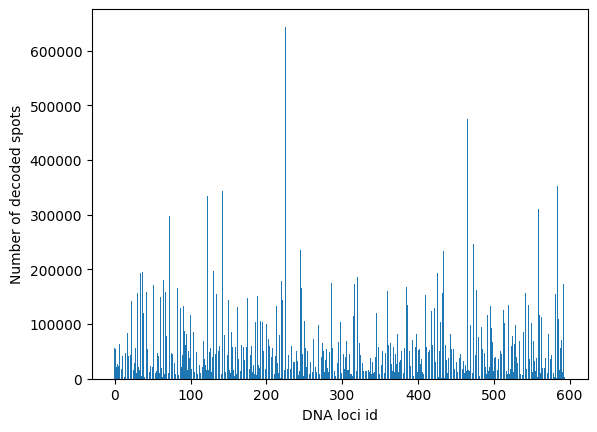

In [46]:
## pre chrom ab
uniq_gene_names, uniq_counts = np.unique(decode_ident[decode_ident < iblank_start], return_counts = True)
plt.bar(uniq_gene_names, uniq_counts)
plt.xlabel('DNA loci id')
plt.ylabel('Number of decoded spots')

Text(0, 0.5, 'Number of decoded spots')

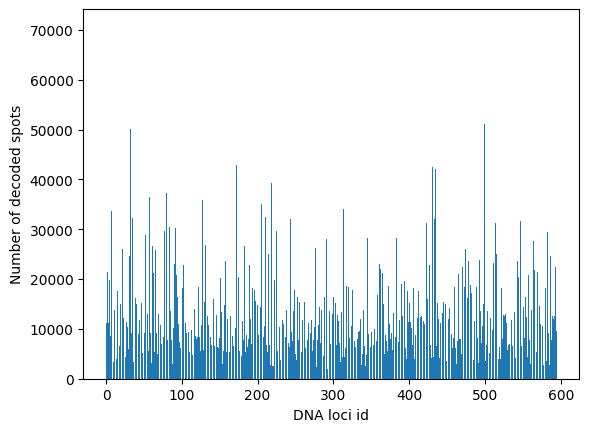

In [20]:
## pre chrom ab
uniq_gene_names, uniq_counts = np.unique(decode_ident[decode_ident < iblank_start], return_counts = True)
plt.bar(uniq_gene_names, uniq_counts)
plt.xlabel('DNA loci id')
plt.ylabel('Number of decoded spots')

In [64]:
np.median(uniq_counts)

42630.0

In [90]:
# manually inspect the locus with lots of spots

In [92]:
# locus with most decoded spots
decode['gns_names'][uniq_gene_names[225]]

'chr1_03864-chr1_03875'

In [89]:
uniq_counts[225]

643895

In [94]:
most_decode_XH = decode['XH_pruned'][np.where(decode['icodesN'] == 225)[0]] #all molecules matching loci 

In [96]:
most_decode_XH.shape

(643895, 4, 10)

In [98]:
most_decode_XH[100]

array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [-8.39516446e-02,  1.90215332e+02,  7.32269821e+01,
        -2.29284302e+03,  2.71205962e-01,  2.05712305e+03,
         5.49888909e-01,  2.40542529e+03,  0.00000000e+00,
         0.00000000e+00],
       [ 8.26806843e-01,  1.88353714e+02,  7.29865341e+01,
        -3.42985522e+03,  4.38183732e-02,  2.99584253e+03,
         2.59783179e-01,  1.52522729e+03,  1.00000000e+00,
         1.00000000e+00],
       [ 6.82106316e-01,  1.89094208e+02,  7.46651459e+01,
        -1.65326831e+03,  1.57851383e-01,  2.15143384e+03,
         5.00975251e-01,  3.45855957e+03,  0.00000000e+00,
         9.00000000e+00]])

In [108]:
# Assuming most_decode_XH is your numpy array
na_mask = np.isnan(most_decode_XH)  # Step 1: Create a mask of where NaNs are
any_na = np.any(na_mask, axis=1)   # Step 2: Check along the second axis
print(f'Percent non na: {1- np.sum(any_na, axis = 0)[0] / len(most_decode_XH)}')

Percent non na: 0.2872129772711389
